In [2]:
import pandas as pd
import numpy as np
import hics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn import svm

1_wHiCS: 10 datasets, each 100 independent features, 40 of them useful  
2_wRaR: 10 datasets, each 30 independent features, 20 of them useful, 70 dependent features  
3_wRaR: 10 datasets, each 100 independent features, 50 of them useful, 100 dependent features  
5_wrar: 1 dataset, 40 independent features, 25 of them useful, 20 dependent  
6_wrar: 3 datasets, 40 independent, 30 useful, 40 dependent  
7_wrar: 4 datasets, 40 independent, 30 useful, 40 dependent   
8_wrar: 4 datasets, each 30 independent features, 20 of them useful, 70 dependent features 

In [39]:
import arff
datas = []
for i in range(1, 4):
    file = open('../data/10_wrar/10_wrar_' + str(i) + '.arff', 'r')
    dataset = arff.load(file)
    file.close()
    data = pd.DataFrame(dataset['data'])
    data[100] = data[100].astype(np.float32)
    data.rename(columns=lambda c: str(c), inplace=True)
    datas.append(data)
target = str(100)

In [52]:
data = datas[1] # pd.concat(datas).reset_index(drop=True)

In [51]:
gini(np.unique(data[target], return_counts=True)[1]/len(data))

0.44653955346044644

In [ ]:
import arff
file = open('../data/5_wrar.arff', 'r')
dataset = arff.load(file)
data = pd.DataFrame(dataset['data'])
data[60] = data[60].astype(np.float32)
data.rename(columns=lambda c: str(c), inplace=True)
target = str(60)

In [58]:
import wrar

rar = wrar.rar.RaR(data)
rar.run(target, k=5, runs=50, split_iterations=10, compensate_imbalance=True)

rar_nocomp = wrar.rar.RaR(data)
rar_nocomp.run(target, k=5, runs=50, split_iterations=10, compensate_imbalance=False)

Generated cost matrix:
         0.0       1.0       2.0      3.0        4.0       5.0        6.0  \
0  11.764706  6.199628  4.106776  4.22833  23.310023  22.83105  41.666667   

         7.0       8.0        9.0  
0  29.069767  8.591065  81.967213  
Overall cost matrix:
         0.0       1.0       2.0      3.0        4.0       5.0        6.0  \
0  11.764706  6.199628  4.106776  4.22833  23.310023  22.83105  41.666667   

         7.0       8.0        9.0  
0  29.069767  8.591065  81.967213  
Relevance: 100.00%    
Running optimizer...
Optimizer done.
defaultdict(<class 'int'>, {'84': 0.21698886098340173, '33': 1.1019020550119053e-08, '80': 0.18278239975704344, '16': 1.1019020550119053e-08, '4': 0.5848320680796163, '57': 0.46830569075542516, '47': 0.0042952459263725946, '39': 0.073451028480874786, '40': 1.1019020550119053e-08, '0': 0.30155742419300119, '88': 1.1019020550119053e-08, '58': 0.36711315832749208, '81': 0.18069230340977985, '76': 0.25217019950415526, '45': 1.1019020550119053

Redundancy: 100.00%    
1. 67 with a score of 0.9994897397672813
2. 8 with a score of 0.8792092567825354
3. 97 with a score of 0.8495771885031183
4. 78 with a score of 0.8160771309178457
5. 89 with a score of 0.73153798396463
6. 80 with a score of 0.7086786928303663
7. 66 with a score of 0.6659319496570231
8. 82 with a score of 0.6584103692195681
9. 70 with a score of 0.6238718679790438
10. 65 with a score of 0.6056024403817243
11. 27 with a score of 0.521363502314585
12. 69 with a score of 0.5077184925673326
13. 16 with a score of 0.5073207031890353
14. 14 with a score of 0.46387488331088683
15. 1 with a score of 0.46374132036820803
16. 72 with a score of 0.4636551005723144
17. 31 with a score of 0.4620843951615249
18. 86 with a score of 0.4564234571146668
19. 22 with a score of 0.4399045532128012
20. 12 with a score of 0.43613624352285313
21. 83 with a score of 0.43609111668254186
22. 13 with a score of 0.41870891170161906
23. 10 with a score of 0.41870537008058956
24. 25 with a scor

In [61]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import cross_val_score
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import LinearSVC

# Train/Test split
X = data.drop(target, axis=1)
y = data[target]

# nm = RandomOverSampler(random_state=45622)
# X_res, y_res = nm.fit_sample(X, y)

# X = pd.DataFrame(X_res, columns=X.columns)
# y = y_res

print(np.unique(y, return_counts=True)[1])

max_k = 50
scores = pd.DataFrame(columns=['wRaR', 'RaR'], index=np.arange(1, max_k + 1)).fillna(0)

rank_columns_nocomp = [r[0] for r in rar_nocomp.feature_ranking]
from sklearn.metrics import f1_score
for k in range(1, max_k + 1):
    # clf = LinearSVC(class_weight='balanced')
    clf = KNeighborsClassifier(n_neighbors=1)
    # clf = GaussianNB()
    f1_macros = cross_val_score(clf, X[rank_columns_nocomp[:k]], y, cv=3, scoring='f1_macro')
    scores.loc[k, 'RaR'] = np.mean(f1_macros)

    # clf.fit(X_train[rank_columns_nocomp[:k]], y_train)
    # y_predict_ideal = clf.predict(X_test[rank_columns_nocomp[:k]])
    # score = f1_score(y_test, y_predict_ideal, average='macro')
    # scores.loc[k, 'RaR'] += score
    # for i, s in enumerate(score):
    #    scores.loc[k, 'RaR' + str(i)] += s

rank_columns = [r[0] for r in rar.feature_ranking]
for k in range(1, max_k + 1):
    # clf_selected = LinearSVC(class_weight='balanced')
    clf_selected = KNeighborsClassifier(n_neighbors=1)
    # clf_selected = GaussianNB()
    f1_macros = cross_val_score(clf_selected, X[rank_columns[:k]], y, cv=3, scoring='f1_macro')
    scores.loc[k, 'wRaR'] = np.mean(f1_macros)
    
    # clf_selected.fit(X_train[rank_columns[:k]], y_train)
    # y_predict = clf_selected.predict(X_test[rank_columns[:k]])
    # score = f1_score(y_test, y_predict, average='macro')
    # scores.loc[k, 'wRaR'] += score
    # for i, s in enumerate(score):
    #    scores.loc[k, 'wRaR' + str(i)] += s

scores.to_csv('final2_wRaR_10wrar_1nn_3cv.csv')
scores

[ 850 1613 2435 2365  429  438  240  344 1164  122]


,wRaR,RaR
1,0.104472,0.102343
2,0.101216,0.111667
3,0.112994,0.110299
4,0.112253,0.119550
5,0.111754,0.120270
6,0.124282,0.117645
7,0.122069,0.113099
8,0.122091,0.115224
9,0.121190,0.121818
10,0.126765,0.119238


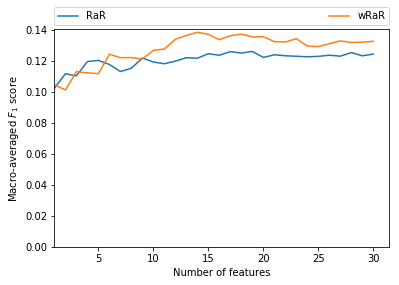

In [63]:
import matplotlib.pyplot as plt
plt.plot(scores['RaR'][:30], label='RaR')
plt.plot(scores['wRaR'][:30], label='wRaR')
ax = plt.gca()
ax.set_xlabel('Number of features')
ax.set_ylabel(r'Macro-averaged $F_1$ score')
ax.set_ylim(0.0)
ax.set_xlim(1)
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
plt.savefig('final2_wRaR_10wrar_1nn_3cv_best30')
plt.show()

In [ ]:
scores

In [ ]:
# Artificially imbalance dataset
class0 = data.loc[data[target] == 0]
class1 = data.loc[data[target] == 1]
imb_data = pd.concat([class1.sample(frac=0.02), class0]).reset_index(drop=True)
# For perfectly balanced dataset, this will result in a 97.56:2.44 ratio

## Ground truth

In [ ]:
# For test7.arff
weights = [0.5335601544927123, 0.759839177764759, 0.772151052808685, 0.7625265610410171,
           0.5612073314384326, 0.34594353279215817, 0.26778115186982904, 0.05104168604756121,
           0.24539066769327755, 0.4298986108981449, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ground_truth = pd.DataFrame(columns=input_features, index=[0])
ground_truth.iloc[0] = weights
# ground_truth.rename(columns=lambda c: int(c), inplace=True)
ground_truth

In [ ]:
# For test8.arff
weights = [0.5335601544927123, 0.759839177764759, 0.772151052808685, 0.7625265610410171,
           0.5612073314384326, 0.34594353279215817, 0.26778115186982904, 0.05104168604756121,
           0.24539066769327755, 0.4298986108981449, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ground_truth = pd.DataFrame(columns=data.columns[:20], index=[0])
ground_truth.iloc[0] = weights
# ground_truth.rename(columns=lambda c: int(c), inplace=True)
ground_truth

In [ ]:
# For test9.arff
weights = [0.7168886878437233, 0.1650913157879492, 0.7017219042598103, 0.5371651431980248,
           0.4012494719087343, 0.08997742462568355, 0.4133240085774441, 0.3003377473503873,
           0.12858013417222078, 0.5857996257919974, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ground_truth = pd.DataFrame(columns=data.columns[:20], index=[0])
ground_truth.iloc[0] = weights
# ground_truth.rename(columns=lambda c: int(c), inplace=True)
ground_truth

In [ ]:
# For test10.arff
weights = [0.2673055187472877, 0.196159223714542, 0.701161636883324, 0.765385125610722,
           0.0011260947105074194, 0.22801651296579062, 0.8949526553930152, 0.13072480437597472,
           0.6333889311003507, 0.7420344156127076, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
           0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
           0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,
           0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
ground_truth = pd.DataFrame(columns=data.columns[:70], index=[0])
ground_truth.iloc[0] = weights
# ground_truth.rename(columns=lambda c: int(c), inplace=True)
ground_truth

In [ ]:
ideal_ranking = ground_truth.sort_values(0, axis=1, ascending=False).columns

## Compensating HiCS

## Standard HiCS

## Testing classifier

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler()
X_res, y_res = rus.fit_sample(X_train, y_train)
X_res = pd.DataFrame(X_res, columns=X_train.columns)
# y_res = pd.DataFrame(y_res, columns=[20])

In [ ]:
counts/len(datas[0])

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

values, counts = np.unique(datas[0][target], return_counts=True)
marg = ax.bar(np.arange(5), counts/len(datas[0]), 0.35, color='green')
cond = ax.bar(np.arange(5) + 0.35, [0.03, 0.05, 0.7, 0.07, 0.15], 0.35, color='orange')
# ax.bar(np.arange(5), counts/len(data), 0.35, color='green')

ax.set_ylabel('Probability')
ax.set_xlabel('Class')
ax.set_title('Marginal and conditional probabilities')
ax.set_xticks(np.arange(5) + 0.35 / 2)
ax.set_xticklabels(('$c_1$', '$c_2$', '$c_3$', '$c_4$', '$c_5$'))
ax.set_ylim([0, 1])

ax.legend((marg, cond), ('Marginal distribution', 'Conditional distribution'))
plt.savefig('marg_cond')

plt.show()

In [ ]:
import warnings
warnings.filterwarnings("default")

In [ ]:
scores

In [ ]:
for data in datas:
    values, counts = np.unique(data[target], return_counts=True)
    print(counts/len(data))

In [ ]:
columns[:3]

In [ ]:
k = 15
results_nocomp = []
rank_columns_nocomp = [r[0] for r in rar_nocomp.feature_ranking]
from sklearn.metrics import f1_score
for j in range(25):
    clf = RandomForestClassifier()
    clf.fit(X_train[rank_columns_nocomp[:k]], y_train)
    y_predict_ideal = clf.predict(X_test[rank_columns_nocomp[:k]])
    results_nocomp.append(f1_score(y_test, y_predict_ideal, average='macro'))

results = []
rank_columns = [r[0] for r in rar.feature_ranking]
for j in range(25):
    clf_selected = RandomForestClassifier()
    clf_selected.fit(X_train[rank_columns[:k]], y_train)
    y_predict = clf_selected.predict(X_test[rank_columns[:k]])
    results.append(f1_score(y_test, y_predict, average='macro'))

print('Dataset 1_whics_' + str(i+1))#, file=log)
print('Weighted RaR macro-weighted F1: ' + str(np.mean(results)))#, file=log)
print('Standard RaR macro-weighted F1: ' + str(np.mean(results_nocomp)))#, file=log)
print('Difference weighted-standard: ' + str(np.mean(results) - np.mean(results_nocomp)))#, file=log)

## Cumulative Gain

In [ ]:
ideal_CG = [ground_truth.loc[0, ideal_ranking[:i].values].sum()
            for i in range(len(ideal_ranking))]
CG = [ground_truth.loc[0, [r for r in rank_columns[:i]]].sum()
      for i in range(len(rank_columns))]
nocomp_CG = [ground_truth.loc[0, [r for r in rank_columns_nocomp[:i]]].sum()
             for i in range(len(rank_columns_nocomp))]

In [ ]:
import matplotlib.pyplot as plt
plt.plot(CG, label='Cumulative Gain Compensating HiCS')
plt.plot(nocomp_CG, label='Cumulative Gain Standard HiCS')
plt.plot(ideal_CG, label='Ideal gain')
plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
# plt.savefig('HiCS_test7_comp_imb2_CG_weightmod1-8')
plt.show()

## Rankings

In [ ]:
rank_columns_nocomp

In [ ]:
rank_columns

In [ ]:
ideal_ranking

In [ ]:
log = open('binary_wHiCS_log.txt', 'w')
for i, data in enumerate(datas):
    # Compensating HiCS
    #
    #
    values, counts = np.unique(data[target], return_counts=True)
    cost_matrix = pd.DataFrame(columns=values)
    for value, count in zip(values, counts):
        weighting = (len(data) / count)
        cost_matrix[value] = [weighting]
    cost_matrix = cost_matrix
    cost_matrix

    from hics.result_storage import DefaultResultStorage
    input_features = [ft for ft in data.columns.values if ft != target]
    storage = DefaultResultStorage(input_features)

    from hics.incremental_correlation import IncrementalCorrelation
    correlation = IncrementalCorrelation(data, target, storage,
                                         iterations=50, alpha=0.1,
                                         drop_discrete=False, cost_matrix=cost_matrix)

    correlation.update_bivariate_relevancies(runs=5)

    ranking = storage.get_relevancies().relevancy.sort_values(ascending=False)
    rank_columns = [tup[0] for tup in ranking.index.values]

    # Standard HiCS
    #
    #
    input_features = [ft for ft in data.columns.values if ft != target]
    storage_nocomp = DefaultResultStorage(input_features)
    correlation_nocomp = IncrementalCorrelation(data, target, storage_nocomp,
                                                iterations=50, alpha=0.1,
                                                drop_discrete=False, cost_matrix=None)

    correlation_nocomp.update_bivariate_relevancies(runs=5)

    ranking_nocomp = storage_nocomp.get_relevancies(
    ).relevancy.sort_values(ascending=False)
    rank_columns_nocomp = [tup[0] for tup in ranking_nocomp.index.values]

    # Train/Test split
    X = data.drop(target, axis=1)
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Test Classifier
    #
    #
    k = 10
    results_nocomp = []
    from sklearn.metrics import f1_score
    for j in range(100):
        clf = RandomForestClassifier()
        clf.fit(X_train[rank_columns_nocomp[:k]], y_train)
        y_predict_ideal = clf.predict(X_test[rank_columns_nocomp[:k]])
        results_nocomp.append(
            f1_score(y_test, y_predict_ideal, average='macro'))

    results = []
    for j in range(100):
        clf_selected = RandomForestClassifier()
        clf_selected.fit(X_train[rank_columns[:k]], y_train)
        y_predict = clf_selected.predict(X_test[rank_columns[:k]])
        results.append(f1_score(y_test, y_predict, average='macro'))
    
    print('Dataset 1_whics_' + str(i+1), file=log)
    print('Weighted RaR macro-weighted F1: ' + str(np.mean(results)), file=log)
    print('Standard RaR macro-weighted F1: ' + str(np.mean(results_nocomp)), file=log)
    print('Difference weighted-standard: ' + str(np.mean(results) - np.mean(results_nocomp)), file=log)
    log.flush()

In [ ]:
import wrar
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_predict

max_k = 50
classes = np.arange(len(np.unique(datas[0][target])))
columns = ['RaR' + str(i) for i in classes] + ['wRaR' + str(i) for i in classes]
scores = pd.DataFrame(columns=columns, index=np.arange(1,max_k+1)).fillna(0)

for data in datas:
    # Compensating RaR
    #
    #
    rar = wrar.rar.RaR(data)
    rar.run(target, k=5, runs=200, split_iterations=10, compensate_imbalance=True)

    # Standard RaR
    #
    #
    rar_nocomp = wrar.rar.RaR(data)
    rar_nocomp.run(target, k=5, runs=200, split_iterations=10, compensate_imbalance=False)

    # Train/Test split
    X = data.drop(target, axis=1)
    y = data[target]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

    # Test Classifier
    #
    #
    rank_columns_nocomp = [r[0] for r in rar_nocomp.feature_ranking]
    from sklearn.metrics import f1_score
    for k in range(1, max_k+1):
        clf = GaussianNB()
        clf.fit(X_train[rank_columns_nocomp[:k]], y_train)
        y_predict_ideal = clf.predict(X_test[rank_columns_nocomp[:k]])
        score = f1_score(y_test, y_predict_ideal, average='macro')
        scores.loc[k, 'RaR'] += score
        for i, s in enumerate(score):
            scores.loc[k, 'RaR' + str(i)] += s
        
    rank_columns = [r[0] for r in rar.feature_ranking]
    for k in range(1, max_k+1):
        clf_selected = GaussianNB()
        clf_selected.fit(X_train[rank_columns[:k]], y_train)
        y_predict = clf_selected.predict(X_test[rank_columns[:k]])
        score = f1_score(y_test, y_predict, average='macro')
        scores.loc[k, 'wRaR'] += score
        for i, s in enumerate(score):
            scores.loc[k, 'wRaR' + str(i)] += s

scores /= len(datas)
scores.to_csv('final_wRaR_3wrar_nb.csv')
scores

In [6]:
def gini(array):
    array = array.flatten()
    if np.amin(array) < 0:
        array -= np.amin(array)
    array += 0.0000001
    array = np.sort(array)
    index = np.arange(1,array.shape[0]+1)
    n = array.shape[0]
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))